In [1]:
import numpy as np
from scipy.io import loadmat
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import clear_output
import imageio
import os

from scipy.io import savemat, loadmat
from scipy.ndimage import gaussian_filter1d as gf1d

from kan import *
from use_training_set import *
import use_KAN
from use_KAN import *


k_z in
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]

alpha in
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]

kappa in
[128.          90.50967     64.          45.254833    32.
  22.627417    16.          11.313708     8.           5.656854
   4.           2.828427     2.           1.4142135    1.
   0.70710677   0.5          0.35355338   0.25         0.17677669]


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# cpu = torch.device('cpu')
# device = cpu

cuda


## load model

In [3]:
with open('setup_model.txt', 'r') as file:
    config = yaml.safe_load(file)
  
use_KAN.set_device(device)  
model_KAN = use_KAN.build_model(config['Model Setup'], device=device)

Device set to: cuda
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


### load trained model parameters

In [4]:
fname_BR = "./saved_model/KAN/model_7_9_grid_ft.pth"
model_KAN.load_state_dict(torch.load(fname_BR))

<All keys matched successfully>

## load training set

In [5]:
config_file = 'setup_ts.txt'
x_train, y_train = load_training_data(config_file)
print(x_train.shape)
print(y_train.shape)
x_train_torch = use_KAN.to_torch_device(x_train, device=device)
y_train_torch = use_KAN.to_torch_device(y_train, device=device)
I_train = np.exp(y_train)


k_z in
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]

alpha in
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]

kappa in
[128.          90.50967     64.          45.254833    32.
  22.627417    16.          11.313708     8.           5.656854
   4.           2.828427     2.           1.4142135    1.
   0.70710677   0.5          0.35355338   0.25         0.17677669]
(2000, 3)
(2000, 126)


## define function to generate I(Q)

In [6]:
def f_IQ_KAN(model, x, Q):
    # Transform x using kan_aug
    n_data = x.shape[0]
    x = x.view(-1, 3)
    x_transformed = model.kan_aug(x)
    
    # Transform Q using to_torch_device
    Q_torch = to_torch_device((Q - 2) / 4, device=device)
    
    # Calculate bg
    bg = (x @ model.A + model.B)
    
    # Expand dimensions to match Q_torch
    x_expanded = x_transformed.unsqueeze(1).expand(-1, Q_torch.size(0), -1)
    Q_expanded = Q_torch.unsqueeze(0).unsqueeze(-1).expand(x.size(0), -1, x.size(-1))
    
    # Combine Q and x
    Q_params = torch.cat([Q_expanded, x_expanded], dim=-1)
    Q_params_reshaped = Q_params.view(-1, Q_params.size(-1))
    
    # Produce f(Q, x) using kan
    f_Q_x = model.kan(Q_params_reshaped)
    f_Q_x_reshaped = f_Q_x.view(x.size(0), Q_torch.size(0))
    
    # Add bg to the final output
    return f_Q_x_reshaped + torch.mean(bg)

## plotting results

In [7]:
set_k_z = np.unique(x_train[:, 0])
set_alpha = np.unique(x_train[:, 2])
set_kappa = np.flip(x_train[:, 1])

/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:798: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:808: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:809: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/Red

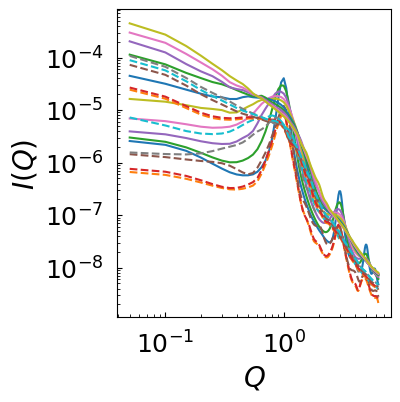

In [8]:
# indexing
def id_params(parameters):
    tol = 1e-6
    id_k_z = np.abs(x_train[:,0]-parameters[0])<tol
    id_kappa = np.abs(x_train[:,1]-parameters[1])<tol
    id_alpha = np.abs(x_train[:,2]-parameters[2])<tol
    
    return np.where(id_k_z*id_alpha*id_kappa)[0][0]

## plot results: varying k_z
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,3,1)

for i, k_z_i in enumerate(set_k_z):
    parameters = [set_k_z[i], set_kappa[0], set_alpha[0]]
    index = id_params(parameters)

    ax.plot(Q,I_train[index,],'-')
    
    I_kan = np.exp(f_IQ_KAN(model_KAN, x_train_torch[index], Q).detach().cpu().numpy())
    ax.plot(Q,I_kan[0],'--')

ax.set_xlabel(r'$Q$',fontsize=20)
ax.set_ylabel(r'$I(Q)$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,100])
# ax.set_ylim([1e-6,2e0])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)